In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Dataset train_sessions

- Primer producto visto
- Fecha de visualización del primer producto
- Último producto visto
- Fecha de visualización del último producto
- Tiempo total de sesión (s)
- Promedio de tiempo en artículos
- Momento del día de inicio de sesión
- Una cadena de productos vistos en orden

In [3]:
df_sessions = pd.read_csv('train_sessions.csv')

In [4]:
df_sessions.head()

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211


In [5]:
session_sorted = df_sessions.sort_values(by=['date'])

# First date of session
begin_df = session_sorted.groupby('session_id')['date'].first().rename('start_date')

# First product of session
first_prod=session_sorted.groupby('session_id')['item_id'].first().rename('first_prod')

# Number of products seen in the session
prod_count=session_sorted.groupby('session_id')['item_id'].count().rename('prod_count')

# Last date of the session
end_df = session_sorted.groupby('session_id')['date'].last().rename('end_date')

# Last product of the session
last_prod=session_sorted.groupby('session_id')['item_id'].first().rename('last_prod')

# Concat the datasets
times_df=pd.concat([begin_df,end_df,first_prod,last_prod,prod_count],axis=1)

# Proper time format
times_df['start_date']=pd.to_datetime(times_df['start_date'])
times_df['end_date']=pd.to_datetime(times_df['end_date'])

# Calculatind the date difference
times_df['time_diff']=(times_df.end_date-times_df.start_date).astype('timedelta64[s]')

# Calculating the time per product
times_df['time_per_prod']=times_df['time_diff']/times_df['prod_count']

# Adding the time of the day
mask=(times_df.start_date.dt.hour>=0) & (times_df.start_date.dt.hour<7)
times_df.loc[mask,'time_first_prod']='madrugada'
mask=(times_df.start_date.dt.hour>=7) & (times_df.start_date.dt.hour<12)
times_df.loc[mask,'time_first_prod']='día'
mask=(times_df.start_date.dt.hour>=12) & (times_df.start_date.dt.hour<18)
times_df.loc[mask,'time_first_prod']='tarde'
mask=(times_df.start_date.dt.hour>=18) & (times_df.start_date.dt.hour<24)
times_df.loc[mask,'time_first_prod']='noche'


In [6]:
# Get the product chain
df_sessions['idx'] = df_sessions.groupby('session_id').cumcount()
df_sessions['item_idx'] = 'product_' + df_sessions.idx.astype(str)

item = df_sessions.pivot(index='session_id',columns='item_idx',values='item_id')

item['item_serie']=item.astype(str).agg('-'.join,axis=1)

item['item_serie'].replace(r'.0','', regex=True, inplace=True)
item['item_serie'].replace(r'-nan','', regex=True, inplace=True)

item.head()

item_idx,product_0,product_1,product_10,product_11,product_12,product_13,product_14,product_15,product_16,product_17,...,product_91,product_92,product_93,product_94,product_95,product_96,product_97,product_98,product_99,item_serie
session_id,,,,,,,,,,,,,,,,,,,,,
3,9655.0,9655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9655-9655
13,15654.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15654
18,18316.0,2507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18316-27-26
19,25772.0,6341.0,8813.0,19896.0,27937.0,23687.0,12804.0,1755.0,18936.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25772-6341-8813-19896-27937-23687-124-1755-189...
24,2927.0,11662.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2927-11662-2927-275-434-164-414-18539-18476


In [7]:
sessions=pd.concat([times_df,item['item_serie']], axis=1)
sessions

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,item_serie
session_id,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,312.0,156.000000,noche,9655-9655
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,0.0,0.000000,noche,15654
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,163.0,54.333333,noche,18316-27-26
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,1082.0,63.647059,tarde,25772-6341-8813-19896-27937-23687-124-1755-189...
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,3703.0,411.444444,tarde,2927-11662-2927-275-434-164-414-18539-18476
...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,533.0,88.833333,día,13914-193-133-232-27733-12373
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,3458.0,314.363636,día,1389-293-293-7833-189-1131-28-17429-62-22551-211
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,0.0,0.000000,noche,25357


# Purchases

In [8]:
purchases = pd.read_csv('train_purchases.csv').set_index('session_id')
purchases['date']=pd.to_datetime(purchases['date'])
purchases.rename(columns={'item_id':'item_purch','date':'purch_date'}, inplace=True)
purchases.head()

,item_purch,purch_date
session_id,,
3,15085,2020-12-18 21:26:47.986
13,18626,2020-03-13 19:36:15.507
18,24911,2020-08-26 19:20:32.049
19,12534,2020-11-02 17:16:45.920
24,13226,2020-02-26 18:27:44.114


In [9]:
purchases.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 3 to 4440001
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   item_purch  1000000 non-null  int64         
 1   purch_date  1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.9 MB


# Features
- Tabla con sesiones y veces que se ha visto cada clúster

In [10]:
item_clust=pd.read_csv('cluster_assign.csv')

In [11]:
item_clust=item_clust[['item_id2', 'Cluster_pred']].set_index('item_id2')
item_clust

,Cluster_pred
item_id2,
2,3
3,4
4,4
7,2
8,4
...,...
28139,0
28140,1
28141,4


In [12]:
df_sess_clust=df_sessions.merge(item_clust, left_on='item_id', right_index=True)
df_sess_clust

,session_id,item_id,date,idx,item_idx,Cluster_pred
0,3,9655,2020-12-18 21:25:00.373,0,product_0,1
1,3,9655,2020-12-18 21:19:48.093,1,product_1,1
103605,97085,9655,2020-12-27 20:22:13.011,3,product_3,1
162423,152155,9655,2020-11-19 16:26:18.468,1,product_1,1
225780,210806,9655,2021-01-02 05:37:37.183,8,product_8,1
...,...,...,...,...,...,...
4737630,4434058,3416,2020-11-14 23:33:46.655,2,product_2,4
4737631,4434058,15964,2020-11-14 23:33:58.652,3,product_3,4
4739963,4436170,27863,2020-07-20 06:36:30.611,0,product_0,2
4741053,4437232,7735,2020-01-02 20:07:06.367,7,product_7,4


In [13]:
df_clust_count = df_sess_clust.groupby(['session_id', 'Cluster_pred'])['session_id'].aggregate('count').unstack().fillna(0)


In [14]:
df_clust_count

Cluster_pred,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
19,14.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
24,0.0,1.0,3.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4439986,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
4439990,7.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4439994,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Combinar los datasets

In [15]:
df=pd.concat([sessions, purchases, df_clust_count], axis=1)
df

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,item_serie,item_purch,...,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,312.0,156.000000,noche,9655-9655,15085,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,0.0,0.000000,noche,15654,18626,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,163.0,54.333333,noche,18316-27-26,24911,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,1082.0,63.647059,tarde,25772-6341-8813-19896-27937-23687-124-1755-189...,12534,...,14.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,3703.0,411.444444,tarde,2927-11662-2927-275-434-164-414-18539-18476,13226,...,0.0,1.0,3.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,533.0,88.833333,día,13914-193-133-232-27733-12373,2915,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,3458.0,314.363636,día,1389-293-293-7833-189-1131-28-17429-62-22551-211,8786,...,7.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,0.0,0.000000,noche,25357,21630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df['item_purch'].nunique()

18907

In [17]:
df.to_csv('dataset_merge.csv')

<AxesSubplot:>

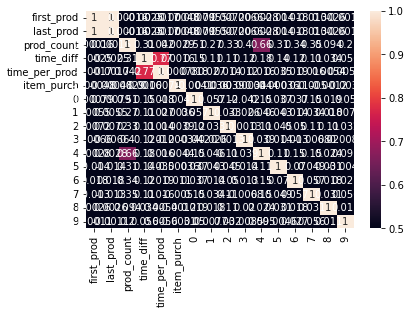

In [18]:
sns.heatmap(df.corr(), annot=True, vmin=0.5) # new 

## Divide into train - validation

There are several ways to divide your training data. Sometimes it is important to create a stratified sampling.

In [19]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
len(train_set),len(test_set)

(800000, 200000)

## Prepare the data for Machine Learning algorithms

In [20]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
df_1hot = cat_encoder.fit_transform(df.fillna('Unknown'))

In [21]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [22]:
df_num = df[["prod_count", "time_diff", "time_per_prod", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [23]:
imputer.fit(df_num)
imputer.statistics_

array([  3., 105.,  30.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.])

In [24]:
df_num.median().values

array([  3., 105.,  30.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.])

In [25]:
X = imputer.transform(df_num)

In [26]:
df_tr = pd.DataFrame(X, columns=df_num.columns,
                          index=df.index)

In [27]:
imputer.strategy

'median'

In [28]:
df_tr.head()

,prod_count,time_diff,time_per_prod,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,,,,
3,2.0,312.0,156.000000,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18,3.0,163.0,54.333333,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
19,17.0,1082.0,63.647059,14.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
24,9.0,3703.0,411.444444,0.0,1.0,3.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0


In [29]:
df_clusts = df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df_clusts = df_clusts.replace(0, np.nan)
df_clusts["distinct"] = df_clusts.count(1)
#df_clusts.head()
item_counts = df_clusts["distinct"].value_counts()
print(item_counts)

1     616053
2     205144
3      95798
4      46570
5      22172
6       9444
7       3529
8       1046
9        224
10        20
Name: distinct, dtype: int64


In [30]:
df_clusts = df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df_clusts = df_clusts.replace(0, np.nan)
df_clusts["sum"] = df_clusts.sum(axis=1)
df_clusts["distinct"] = df_clusts[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]].count(1)
df_clusts = df_clusts[df_clusts["sum"] > 1.0]
df_clusts.head()
#item_counts = df_clusts["distinct"].value_counts()
#print(item_counts)

,0,1,2,3,4,5,6,7,8,9,sum,distinct
session_id,,,,,,,,,,,,
3,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1
18,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,1
19,14.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,17.0,2
24,NaN,1.0,3.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,9.0,4
28,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,1


### Categorical data

Now let's preprocess the categorical input time_first_prod:

In [31]:
df_cat = df[["first_prod", "last_prod", "time_first_prod"]]
# There is missing values in this category, we will create a new cateogry for those.
df_cat.fillna('Unknown').head(10)

,first_prod,last_prod,time_first_prod
session_id,,,
3,9655,9655,noche
13,15654,15654,noche
18,4026,4026,noche
19,19896,19896,tarde
24,2927,2927,tarde
28,16895,16895,tarde
31,25972,25972,noche
36,25417,25417,día
42,20523,20523,tarde


In [32]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df_cat_encoded = ordinal_encoder.fit_transform(df_cat.fillna('Unknown'))
df_cat_encoded[:10]

array([[7.2630e+03, 7.2630e+03, 2.0000e+00],
       [1.1784e+04, 1.1784e+04, 2.0000e+00],
       [3.0020e+03, 3.0020e+03, 2.0000e+00],
       [1.5000e+04, 1.5000e+04, 3.0000e+00],
       [2.1910e+03, 2.1910e+03, 3.0000e+00],
       [1.2734e+04, 1.2734e+04, 3.0000e+00],
       [1.9556e+04, 1.9556e+04, 2.0000e+00],
       [1.9156e+04, 1.9156e+04, 0.0000e+00],
       [1.5477e+04, 1.5477e+04, 3.0000e+00],
       [1.7142e+04, 1.7142e+04, 2.0000e+00]])

In [33]:
ordinal_encoder.categories_

[array([    2,     3,     4, ..., 28140, 28141, 28143]),
 array([    2,     3,     4, ..., 28140, 28141, 28143]),
 array(['día', 'madrugada', 'noche', 'tarde'], dtype=object)]

In [34]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
df_cat_1hot = cat_encoder.fit_transform(df_cat.fillna('Unknown'))
df_cat_1hot

<1000000x42318 sparse matrix of type '<class 'numpy.float64'>'
	with 3000000 stored elements in Compressed Sparse Row format>

In [35]:
df_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

df_num_tr = num_pipeline.fit_transform(df_num)

In [37]:
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

In [38]:
from sklearn.compose import ColumnTransformer

num_attribs1 = df_num.select_dtypes(include="object").columns
cat_attribs = df_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
    ])

df_prepared = full_pipeline.fit_transform(df)

df_prepared

<1000000x4 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

## Select and train a model

### Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df[["item_purch"]])

LinearRegression()

In [40]:
from sklearn.metrics import mean_squared_error

df_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(df[["item_purch"]], df_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

8187.975597682556

RandomForestRegressor

In [41]:
## Let's try another model: Random Forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=20, random_state=42)

In [42]:
forest_reg.fit(df_prepared, df[["item_purch"]].to_numpy().ravel())
df_predictions = forest_reg.predict(df_prepared)
forest_mse = mean_squared_error(df[["item_purch"]].to_numpy().ravel(), df_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse
forest_reg.score(df_prepared, df[["item_purch"]].to_numpy().ravel())
#forest_reg.predict()

3.1542292189268295e-06

In [43]:
forest_reg.predict_proba()

AttributeError: 'RandomForestRegressor' object has no attribute 'predict_proba'